# **In this file we use Blanced DeepSentiPers Dataset for binary SA**



# Preparing Sys required

## check GPU

In [ ]:
!nvidia-smi #The NVIDIA System Management Interface (nvidia-smi) is a command line utility, intended to aid in the management and monitoring of NVIDIA GPU devices. 

Mon Jul  5 14:02:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install required packages

In [ ]:
!pip install -q transformers==3

!pip install -q hazm
!pip install -q clean-text[gpl]

     |████████████████████████████████| 757kB 31.2MB/s 
     |████████████████████████████████| 3.0MB 43.4MB/s 
     |████████████████████████████████| 1.2MB 47.1MB/s 
     |████████████████████████████████| 901kB 37.4MB/s 
     |████████████████████████████████| 317kB 27.6MB/s 
     |████████████████████████████████| 235kB 58.6MB/s 
     |████████████████████████████████| 1.4MB 40.2MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 133kB 34.0MB/s 
     |████████████████████████████████| 245kB 40.5MB/s 


## Import required packages

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import requests
import os
import io
import re
import json
import copy
import collections

# Balanced Dataset

We are going to use [Balanced DeepSentiPers Dataset](https://github.com/JoyeBright/DeepSentiPers/tree/master/Dataset) here.
<table style="width:100%">
  <tr>
    <th>Polarity</th>
    <th>-2</th>
    <th>-1</th>
    <th>0</th>
    <th>+1</th>
    <th>+2</th>
  </tr>
  <tr>
    <td>Original (SentiPers) DS</td>
    <td>28</td>
    <td>513</td>
    <td>2409</td>
    <td>1623</td>
    <td>988</td>
  </tr>
    <tr>
    <td>Balanced DS</td>
    <td>158</td>
    <td>937</td>
    <td>2000</td>
    <td>2000</td>
    <td>1928</td>
  </tr>
</table>



## Load

In [ ]:
#Loading a csv file from GitHub
url = "https://raw.githubusercontent.com/JoyeBright/DeepSentiPers/master/Dataset/balanced.csv" 
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
data = pd.read_csv(io.StringIO(download.decode('utf-8')))
data.set_axis(['comment', 'rate'], axis='columns', inplace=True)

# Printing out the first 5 rows of the dataframe
print('The first 5 rows of the dataset: \n', data.head())

The first 5 rows of the dataset: 
                                              comment  rate
0  کارت‌های حافظه ای که معمولا بر روی گوشی‌های هو...     0
1  اندازه رزولوشن نمایشگر iPod دقیقا همانند iPhon...     0
2  اما صفحه نمایش دوربین فیلمبرداری JVC GZ-MG335،...     0
3  نهایتا، بر روی قاب پشتی گوشی نیز، دوربین به هم...     0
4  ایسوس در پایین این گوشی یک پورت ترکیبی قرار دا...     0


In [ ]:
# print data information
print('data information: \n')
print(data.info())

data information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  7022 non-null   object
 1   rate     7022 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 109.8+ KB
None


## Preprocessing


In [ ]:
unique_ratesB = list(sorted(data['rate'].unique()))
print(f'We have #{len(unique_ratesB)} in Blanced DS:: {unique_ratesB}')

We have #5 in Blanced DS:: [-2, -1, 0, 1, 2]


In [ ]:
fig = go.Figure()

BT_groupby_rate = data.groupby('rate')['rate'].count()

fig.add_trace(go.Bar(
    x=list(sorted(BT_groupby_rate.index)),
    y=BT_groupby_rate.tolist(),
    text=BT_groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

### Binarization DS use NN Approch.

NN: Considering neutral emotions as negative

In [ ]:
def Brate_to_label(Brate):
    if Brate <= 0:
        return 'negative'
    else:
      return 'positive'


data['label'] = data['rate'].apply(lambda t: Brate_to_label(t))
Blabels = list(sorted(data['label'].unique()))
data.head()


,comment,rate,label
0,کارت‌های حافظه ای که معمولا بر روی گوشی‌های هو...,0,negative
1,اندازه رزولوشن نمایشگر iPod دقیقا همانند iPhon...,0,negative
2,اما صفحه نمایش دوربین فیلمبرداری JVC GZ-MG335،...,0,negative
3,نهایتا، بر روی قاب پشتی گوشی نیز، دوربین به هم...,0,negative
4,ایسوس در پایین این گوشی یک پورت ترکیبی قرار دا...,0,negative


In [ ]:
Bgroupby_label = data.groupby('label')['label'].count()

Bgroupby_label = dict(Bgroupby_label)
print(Bgroupby_label)

{'negative': 3094, 'positive': 3928}


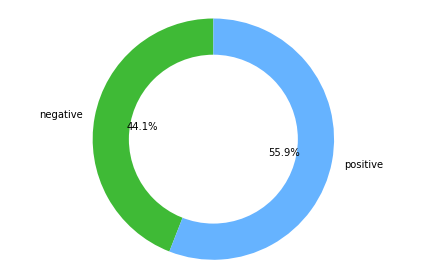

In [ ]:
labels = list(Bgroupby_label.keys())
sizes = list(Bgroupby_label.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
plt.show()

As it expected, dataset is still balanced.

### Cleaning 
is the final step in this section, and becase **DeepSentiPers** had five different preprocessing steps were applied to all the sentences (Normalization, Punctuation rmoval, Single character removal, Digits removal and Lemmatization), so Our cleaned method includes these steps:
- fixing unicodes
- removing specials like an email, url, new lines, ...
- cleaning HTMLs
- removing emojis

In [ ]:
import re
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,                 # fix various unicode errors
        to_ascii=False,                   # transliterate to closest ASCII representation
        lower=True,                       # lowercase text
        no_line_breaks=True,              # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                     # replace all URLs with a special token
        no_emails=True,                   # replace all email addresses with a special token
        no_phone_numbers=True,            # replace all phone numbers with a special token
        no_numbers=False,                 # replace all numbers with a special token
        no_digits=False,                  # replace all digits with a special token
        no_currency_symbols=True,         # replace all currency symbols with a special token
        no_punct=False,                   # remove punctuations
        replace_with_url="",              # instead of removing URL replace them by noyhing
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",  
        #lang="en"                       # set to 'de' for German special handling
        # So far, only English and German are fully supported. It should work for the majority of western languages.
    )


    # cleaning htmls
    text = cleanhtml(text) 
   
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [ ]:
# cleaning comments
data['cleaned_comment'] = data['comment'].apply(cleaning)


# # calculate the length of comments based on their words
# data['cleaned_comment_len_by_words'] = data['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

# # remove comments with the length of fewer than 2 words
# data['cleaned_comment_len_by_words'] = data['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim <= len_t <= maxlim else len_t)
# data = data.dropna(subset=['cleaned_comment_len_by_words'])
# data = data.reset_index(drop=True)

data.head()

,comment,rate,label,cleaned_comment
0,کارت‌های حافظه ای که معمولا بر روی گوشی‌های هو...,0,negative,کارت‌های حافظه ای که معمولا بر روی گوشی‌های هو...
1,اندازه رزولوشن نمایشگر iPod دقیقا همانند iPhon...,0,negative,اندازه رزولوشن نمایشگر ipod دقیقا همانند iphon...
2,اما صفحه نمایش دوربین فیلمبرداری JVC GZ-MG335،...,0,negative,اما صفحه نمایش دوربین فیلمبرداری jvc gz-mg335،...
3,نهایتا، بر روی قاب پشتی گوشی نیز، دوربین به هم...,0,negative,نهایتا، بر روی قاب پشتی گوشی نیز، دوربین به هم...
4,ایسوس در پایین این گوشی یک پورت ترکیبی قرار دا...,0,negative,ایسوس در پایین این گوشی یک پورت ترکیبی قرار دا...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   comment          7022 non-null   object
 1   rate             7022 non-null   int64 
 2   label            7022 non-null   object
 3   cleaned_comment  7022 non-null   object
dtypes: int64(1), object(3)
memory usage: 219.6+ KB


In [ ]:
data = data[['cleaned_comment', 'label']]
data.columns = ['comment', 'label']
data.head()

,comment,label
0,کارت‌های حافظه ای که معمولا بر روی گوشی‌های هو...,negative
1,اندازه رزولوشن نمایشگر ipod دقیقا همانند iphon...,negative
2,اما صفحه نمایش دوربین فیلمبرداری jvc gz-mg335،...,negative
3,نهایتا، بر روی قاب پشتی گوشی نیز، دوربین به هم...,negative
4,ایسوس در پایین این گوشی یک پورت ترکیبی قرار دا...,negative


In [ ]:
print(f'We have #{len(labels)} labels: {labels}')

We have #2 labels: ['negative', 'positive']


In [ ]:
# See the data number of sentence in each category and is it balanced?
GroupbyLabel = data.groupby('label')['label'].count()

GroupbyLabel = dict(GroupbyLabel)
print(GroupbyLabel)

{'negative': 3094, 'positive': 3928}


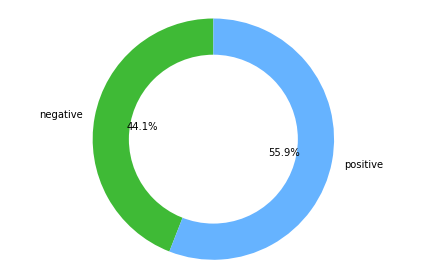

In [ ]:
labels = list(GroupbyLabel.keys())
sizes = list(GroupbyLabel.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
plt.show()

The dataset is still balanced, so we are going to fine-tuning model

# Train,Validation,Test split

We need to split the balanced cleaned dataset into train, valid and test sets due to size of the data. 

In this tutorial, we have considered a rate of **0.1** for both *valid*, *test* sets. For splitting, we use `train_test_split` provided by Sklearn package with stratifying on the label for preserving the distribution balance.

In [ ]:
new_data = data
new_data = new_data.sample(frac=1).reset_index(drop=True) # we shuffle the order of the DataFrame's rows,
                                                          # so that all Type's are mixed.
new_data.info()
new_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  7022 non-null   object
 1   label    7022 non-null   object
dtypes: object(2)
memory usage: 109.8+ KB


,comment,label
0,اما این کار فقط تا 1.5 ثانیه 15 عکس می‌تواند ص...,negative
1,در کل همانطور که گفتیم، دوربین های سامسونگ st6...,positive
2,با همان ابعاد تنها گرم سنگین‌تر.,negative
3,کپی این دستگاه با داشتن پرینتر اسکنر، دارای ام...,negative
4,در پایین آن نیز درگاه اتصال شارژ تبلت به علاوه...,negative


In [ ]:
new_data['label_id'] = new_data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(new_data, test_size=0.1, random_state=1, stratify=new_data['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(5687, 3)
(632, 3)
(703, 3)


In [ ]:
new_data.head()

,comment,label,label_id
0,اما این کار فقط تا 1.5 ثانیه 15 عکس می‌تواند ص...,negative,0
1,در کل همانطور که گفتیم، دوربین های سامسونگ st6...,positive,1
2,با همان ابعاد تنها گرم سنگین‌تر.,negative,0
3,کپی این دستگاه با داشتن پرینتر اسکنر، دارای ام...,negative,0
4,در پایین آن نیز درگاه اتصال شارژ تبلت به علاوه...,negative,0


## Using PyTorch

### Import required packages

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

### Configuration

####Select GPU
A GPU can be added by going to the menu and selecting one of the falowing 2:

  1- Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)
  <br/>
  2- Runtime 🡒  change runtime type 🡒 Hardware accelerator 🡒 (GPU)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


####General configuration

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
#MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-zwnj-base'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


In [ ]:
# setup the tokenizer and configuration

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())


{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 100000
}



In [ ]:
idx = np.random.randint(0, len(train))
sample_comment = train.iloc[idx]['comment']
sample_label = train.iloc[idx]['label']

print(f'Sample: \n{sample_comment}\n{sample_label}')

Sample: 
هرچند که انتظار داشتیم کیفیت آن بهتر می‌شد دست کم به 460,000 پیکسل افزایش می‌داد ولی به هر صورت نمایشگر روشن خوبی است.
positive


In [ ]:
tokens = tokenizer.tokenize(sample_comment)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Comment: {sample_comment}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

  Comment: هرچند که انتظار داشتیم کیفیت آن بهتر می‌شد دست کم به 460,000 پیکسل افزایش می‌داد ولی به هر صورت نمایشگر روشن خوبی است.
   Tokens: هرچند که انتظار داشتیم کیفیت ان بهتر [UNK] دست کم به [UNK] , [UNK] پیکسل افزایش [UNK] ولی به هر صورت نمایشگر روشن خوبی است .
Token IDs: [5692, 2800, 4378, 7363, 4589, 2808, 4109, 1, 2910, 2961, 2789, 1, 1010, 1, 9550, 3191, 1, 3362, 2789, 2937, 3080, 6689, 4659, 3949, 2806, 1012]


In [ ]:
encoding = tokenizer.encode_plus(
    sample_comment,
    max_length=32,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[   2, 5692, 2800, 4378, 7363, 4589, 2808, 4109,    1, 2910, 2961, 2789,
            1, 1010,    1, 9550, 3191,    1, 3362, 2789, 2937, 3080, 6689, 4659,
         3949, 2806, 1012,    4,    0,    0,    0,    0]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0]])


In [ ]:
class BDSPDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for BDSPDataset. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = BDSPDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
label_list = ['negative', 'positive']
train_data_loader = create_data_loader(train['comment'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['comment'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['comment'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
sample_data = next(iter(train_data_loader))

print(sample_data.keys())

print(sample_data['comment'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'].shape)
print(sample_data['targets'][0])

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
['يکي از مشکلات بزرگ باتريشه چون بعد از 300 يا 400 بار شارژ يعني حدودا سال استفاده به شدت ضعيف مي شه قابل استفاده نيست عوض کردن باتريش هم با توجه به وسايل خاصي که فقط نمايندگي هاي مجاز اپل در کشورهاي مختلف دارن امکان پذيره در صورتي که در ايران اين کار با پيچ گوشتي ..', 'این دوربین با وزن تنها 167 گرم، آن قدر کوچک سبک است که می توان آن را برای پژوهش های علمی رفتار حیوانات بر روی بدن یک حیوان یا برای فیلم برداری هوایی بر روی یک هلیکوپتر کنترل از راه دور یا یک بالون هم نصب کرد!', 'اما پس از خود گوشی نوبت به داک تبلت آن می\u200cرسد که همراه با گوشی عرضه می\u200cشود.', 'مثل: نداشتن دوربين مکالمه تصويري', 'اما بر خلاف بسیاری از گوشی\u200cها، کلید پاور کلید کنترل صدای این گوشی در کنار یکدیگر نیستند یکی بر روی لبه سمت چپ دیگری بر روی لبه سمت راست گوشی تعبیه شده است.', 'کيفيت full hd فيلمبرداريش حرف نداره', 'در جواب جناب عطاالله بيگ زاده در مورد اشکالي که گرفتن: توي نسخه شماره آندرويد، شما با سيم کارت\u200cهاي اي

In [ ]:
sample_test = next(iter(test_data_loader))
print(sample_test.keys())

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids'])


### Model

In [ ]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

Mon Jul  5 14:17:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['bert.embeddings.position_ids']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [ ]:
# sample data output

sample_data_comment = sample_data['comment']
sample_data_input_ids = sample_data['input_ids']
sample_data_attention_mask = sample_data['attention_mask']
sample_data_token_type_ids = sample_data['token_type_ids']
sample_data_targets = sample_data['targets']

# available for using in GPU
sample_data_input_ids = sample_data_input_ids.to(device)
sample_data_attention_mask = sample_data_attention_mask.to(device)
sample_data_token_type_ids = sample_data_token_type_ids.to(device)
sample_data_targets = sample_data_targets.to(device)


# outputs = F.softmax(
#     pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids), 
#     dim=1)

outputs = pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids)
_, preds = torch.max(outputs, dim=1)

print(outputs[:5, :])
print(preds[:5])

tensor([[-0.0809,  0.2207],
        [-0.6443, -0.1529],
        [ 0.2407, -0.1610],
        [-0.0398,  0.3026],
        [-0.1774, -0.0810]], device='cuda:0', grad_fn=<SliceBackward>)
tensor([1, 1, 0, 1, 1], device='cuda:0')


### Training

In [ ]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model, 
        data_loader=train_data_loader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        step=step, 
        print_every_step=EEVERY_EPOCH, 
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader, 
        clip=CLIP)
    
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(
        model=pt_model, 
        data_loader=valid_data_loader, 
        loss_fn=loss_fn)
    
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)


Epoch: 3/3...Step: 1000...Train Loss: 0.112052...Train Acc: 0.961...Valid Loss: 0.581245...Valid Acc: 0.831...
Validation loss decreased (inf --> 0.581245).  Saving model ...



### Prediction

In [ ]:
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
test_comments = test['comment'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=128)

print(preds.shape, probs.shape)


(703,) (703, 2)


In [ ]:
y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds

print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print()
print(classification_report(y_test, y_pred, target_names=label_list))

F1: 0.8533525435385092

              precision    recall  f1-score   support

    negative       0.84      0.83      0.83       310
    positive       0.86      0.88      0.87       393

    accuracy                           0.85       703
   macro avg       0.85      0.85      0.85       703
weighted avg       0.85      0.85      0.85       703



## Using TensorFlow

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features

import tensorflow as tf

### Configuration

In [ ]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 100000
}



### Input Embeddings / Dataset

In [ ]:
class InputExample:
    """ A single example for simple sequence classification. """

    def __init__(self, guid, text_a, text_b=None, label=None):
        """ Constructs a InputExample. """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


def make_examples(tokenizer, x, y=None, maxlen=128, output_mode="classification", is_tf_dataset=True):
    examples = []
    y = y if isinstance(y, list) or isinstance(y, np.ndarray) else [None] * len(x)

    for i, (_x, _y) in tqdm(enumerate(zip(x, y)), position=0, total=len(x)):
        guid = "%s" % i
        label = int(_y)
        
        if isinstance(_x, str):
            text_a = _x
            text_b = None
        else:
            assert len(_x) == 2
            text_a = _x[0]
            text_b = _x[1]
        
        examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    
    features = glue_convert_examples_to_features(
        examples, 
        tokenizer, 
        maxlen, 
        output_mode=output_mode, 
        label_list=list(np.unique(y)))

    all_input_ids = []
    all_attention_masks = []
    all_token_type_ids = []
    all_labels = []

    for f in tqdm(features, position=0, total=len(examples)):
        if is_tf_dataset:
            all_input_ids.append(tf.constant(f.input_ids))
            all_attention_masks.append(tf.constant(f.attention_mask))
            all_token_type_ids.append(tf.constant(f.token_type_ids))
            all_labels.append(tf.constant(f.label))
        else:
            all_input_ids.append(f.input_ids)
            all_attention_masks.append(f.attention_mask)
            all_token_type_ids.append(f.token_type_ids)
            all_labels.append(f.label)

    if is_tf_dataset:
        dataset = tf.data.Dataset.from_tensor_slices(({
            'input_ids': all_input_ids,
            'attention_mask': all_attention_masks,
            'token_type_ids': all_token_type_ids
        }, all_labels))

        return dataset, features
    
    xdata = [np.array(all_input_ids), np.array(all_attention_masks), np.array(all_token_type_ids)]
    ydata = all_labels

    return [xdata, ydata], features

In [ ]:
train_dataset_base, train_examples = make_examples(tokenizer, x_train, y_train, maxlen=128)
valid_dataset_base, valid_examples = make_examples(tokenizer, x_valid, y_valid, maxlen=128)

test_dataset_base, test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128)
[xtest, ytest], test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128, is_tf_dataset=False)

In [ ]:
for value in train_dataset_base.take(1):
    print(f'     input_ids: {value[0]["input_ids"]}')
    print(f'attention_mask: {value[0]["attention_mask"]}')
    print(f'token_type_ids: {value[0]["token_type_ids"]}')
    print(f'        target: {value[1]}')

     input_ids: [    2  1381  2004  2038  2791  3966  3167 42660  2038  5448  3633  3082
  2791     1  1381  2006     1  3163  7450  1381 35067  2038 10563  2844
  2988  2789  4931 25853  2038  2028 59767  3232  3496  2988 14647  2787
  6728  3274 42660  2038  2014  2820  2799  3211  2789 22581  3643  2038
  2800  3765 22696  2790  2012  2038 20891  5660  5743  2786  5213  2038
  3431 15559  3657  8589 19682  2008  2786  3080  2038  2800  2786  8568
  3414  8568  2011  2867  2799  1407  2038  2021  5835  2038  1012  1012
     4     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
attention_mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0

In [ ]:
def get_training_dataset(dataset, batch_size):
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)

    return dataset

def get_validation_dataset(dataset, batch_size):
    dataset = dataset.batch(batch_size)

    return dataset

In [ ]:
train_dataset = get_training_dataset(train_dataset_base, TRAIN_BATCH_SIZE)
valid_dataset = get_training_dataset(valid_dataset_base, VALID_BATCH_SIZE)

train_steps = len(train_examples) // TRAIN_BATCH_SIZE
valid_steps = len(valid_examples) // VALID_BATCH_SIZE

train_steps, valid_steps

(355, 39)

### Model

In [ ]:
def build_model(model_name, config, learning_rate=3e-5):
    model = TFBertForSequenceClassification.from_pretrained(model_name, config=config)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    return model

In [ ]:
model = build_model(MODEL_NAME_OR_PATH, config, learning_rate=LEARNING_RATE)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier', 'dropout_37']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

In [ ]:
%%time

r = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    epochs=EPOCHS,
    verbose=1)

final_accuracy = r.history['val_accuracy']
print('FINAL ACCURACY MEAN: ', np.mean(final_accuracy))

Epoch 1/3
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
355/355 [==============================] - 178s 455ms/step - loss: 0.4634 - accuracy: 0.7704 - val_loss: 0.4324 - val_accuracy: 0.8269
Epoch 2/3
355/355 [==============================] - 160s 450ms/step - loss: 0.2804 - accuracy: 0.8894 - val_loss: 0.4823 - val_accuracy: 0.8269
Epoch 3/3
355/355 [==============================] - 160s 450ms/step - loss: 0.1730 - accuracy: 0.9356 - val_loss: 0.5355 - val_accuracy: 0.8205
FINAL ACCURACY MEAN:  0.8247863252957662
CPU times: user 2min 40s, sys: 1min 7s, total: 3min 47s
Wall time: 8min 38s


In [ ]:
# save the model
model.save_pretrained(os.path.dirname(OUTPUT_PATH))

### Evaluation / Prediction

In [ ]:
ev = model.evaluate(test_dataset_base.batch(TEST_BATCH_SIZE))
print()
print(f'Evaluation: {ev}')
print()

predictions = model.predict(xtest)
ypred = predictions[0].argmax(axis=-1).tolist()

print()
print(classification_report(ytest, ypred, target_names=labels))
print()

print(f'F1: {f1_score(ytest, ypred, average="weighted")}')

44/44 [==============================] - 6s 143ms/step - loss: 0.4597 - accuracy: 0.8407

Evaluation: [0.4597034156322479, 0.8406828045845032]


              precision    recall  f1-score   support

    negative       0.79      0.87      0.83       310
    positive       0.89      0.81      0.85       393

    accuracy                           0.84       703
   macro avg       0.84      0.84      0.84       703
weighted avg       0.85      0.84      0.84       703


F1: 0.8412224752362624


#Select GPU
A GPU can be added by going to the menu and selecting one of the falowing 2:

  1- Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)
  <br/>
  2- Runtime 🡒  change runtime type 🡒 Hardware accelerator 🡒 (GPU)

In [ ]:
#Run the following cell to confirm that the GPU is detected.

import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


# Source
[Loading a csv file from GitHub in Python](https://medium.com/towards-entrepreneurship/importing-a-csv-file-from-github-in-a-jupyter-notebook-e2c28e7e74a5)